<a href="https://colab.research.google.com/github/kairamilanifitria/PurpleBox-Intern/blob/main/RAG/4_EMBEDDING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install supabase numpy psycopg2

In [ ]:
import os
import json
import torch
import uuid
import numpy as np
from supabase import create_client, Client
from transformers import AutoTokenizer, AutoModel

# Initialize Supabase
#SUPABASE_URL = "_______________"
#SUPABASE_KEY = "_______________"
SUPABASE_URL = "_______________________"
SUPABASE_KEY = "_______________________"

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

# Load Embedding Model
tokenizer = AutoTokenizer.from_pretrained("Alibaba-NLP/gte-multilingual-base", trust_remote_code=True)
model = AutoModel.from_pretrained("Alibaba-NLP/gte-multilingual-base", trust_remote_code=True).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [3]:
def get_embedding(text):
    """Generates an embedding vector from input text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().tolist()

def generate_table_description(table_data):
    """Generates a natural language description from a table's headers and rows."""
    headers = table_data["headers"]
    rows = table_data["rows"]

    description = []
    for row in rows:
        row_text = ", ".join([f"{headers[i]}: {row[i]}" for i in range(len(headers))])
        description.append(row_text)

    return " | ".join(description)  # Separate rows with "|"

def convert_table_to_text(table_data, metadata):
    """Converts a table (headers + rows) into a structured text format with metadata and description for embedding."""
    headers = ", ".join(table_data["headers"])
    rows = [" | ".join(row) for row in table_data["rows"]]

    # Retrieve metadata fields
    table_title = metadata.get("table_title", "Unknown Table")
    section = metadata.get("section", "Unknown Section")

    # Generate description from table data
    table_description = generate_table_description(table_data)

    # Combine metadata with table content
    return (
        f"Table Title: {table_title}. Section: {section}.\n"
        f"Table Data:\nHeaders: {headers}\n" + "\n".join(rows) +
        f"\nDescription: {table_description}"
    ), table_description  # Return both formatted text & natural description

def store_chunks_in_supabase(chunks):
    """Stores text and table chunks into Supabase with improved embeddings."""
    document_entries = []
    table_entries = []

    for chunk in chunks:
        chunk_id = str(uuid.uuid4())  # Generate unique chunk_id

        # Process text content
        if "content" in chunk and chunk["content"]:
            content = chunk["content"]
            embedding = get_embedding(content)

            document_entries.append({
                "chunk_id": chunk_id,
                "content": content,
                "embedding": embedding,
                "metadata": chunk["metadata"],
                "type": "text"
            })

        # Process table data
        if "table" in chunk and chunk["table"]:
            table_data = chunk["table"]
            metadata = chunk.get("metadata", {})

            # Generate both structured table text & natural description
            table_text, table_description = convert_table_to_text(table_data, metadata)
            table_embedding = get_embedding(table_text)

            table_entries.append({
                "chunk_id": chunk_id,
                "table_data": json.dumps(table_data, ensure_ascii=False),
                "description": table_description,  # Store the generated description
                "embedding": table_embedding,
                "metadata": metadata
            })

    # Batch insert into Supabase
    if document_entries:
        supabase.table("documents").insert(document_entries).execute()
    if table_entries:
        supabase.table("tables").insert(table_entries).execute()


In [ ]:
# Load JSON chunks
json_file_path = "__________.json"
with open(json_file_path, "r", encoding="utf-8") as json_file:
    json_chunks = json.load(json_file)

# Store chunks in Supabase
store_chunks_in_supabase(json_chunks)
print("Text and table embeddings stored successfully in Supabase!")


Note: use 2 table for the project. `"documents"` and `"tables"`

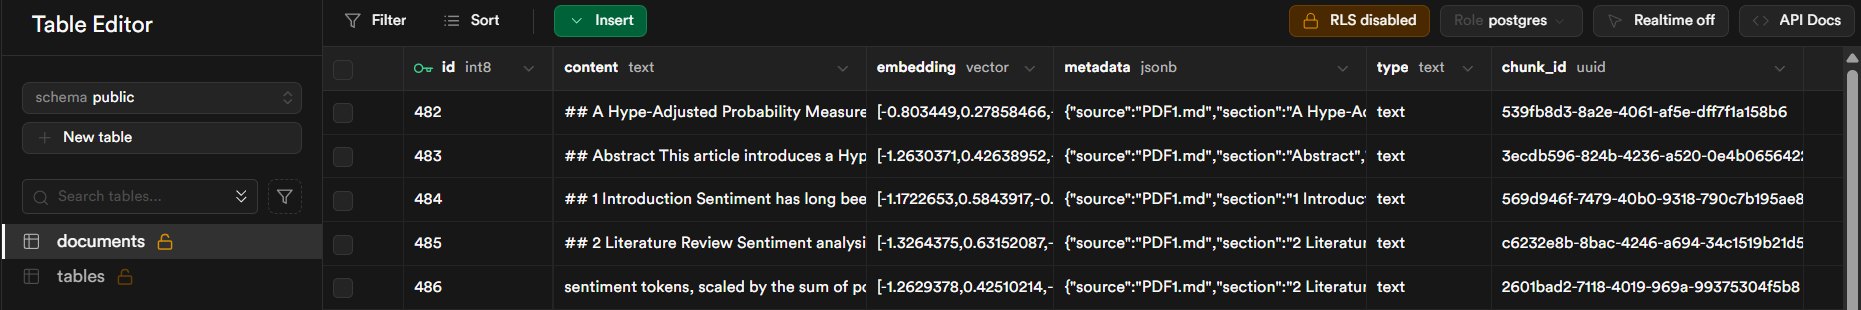

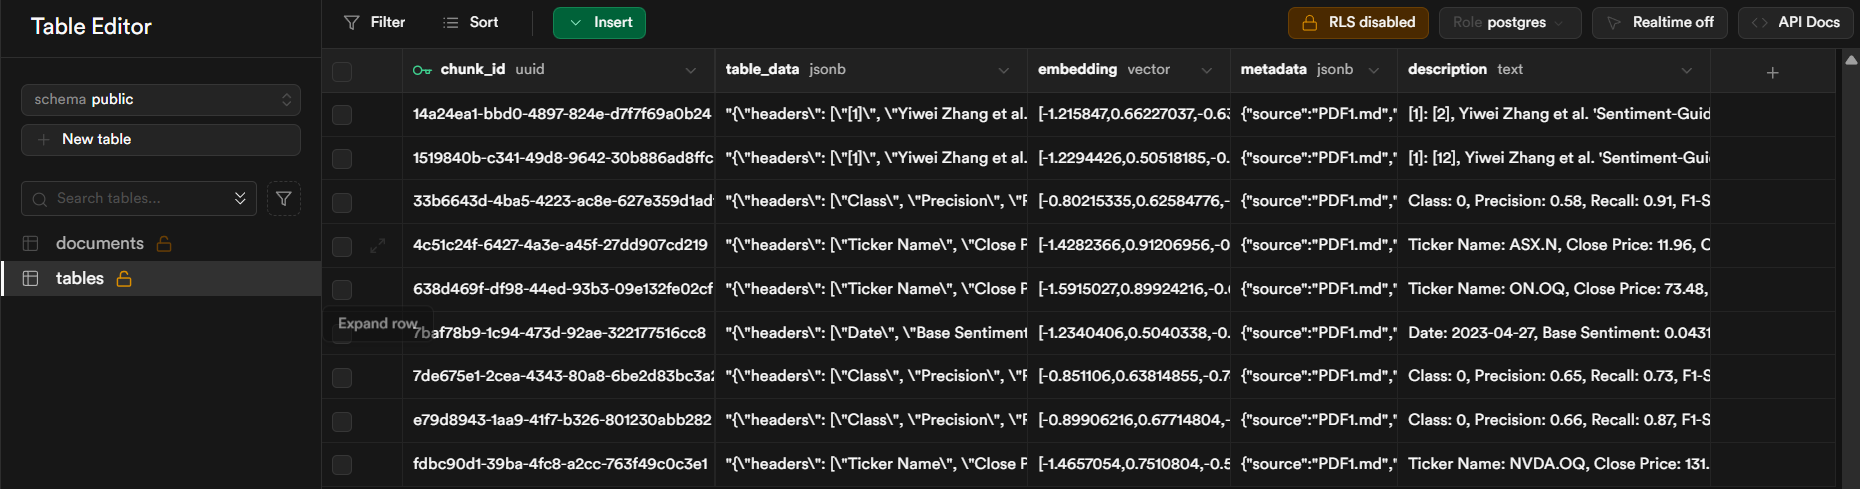